<a href="https://colab.research.google.com/github/rutgerhofste/aqueduct30_plot/blob/master/Y2019M07D24_RH_Aqueduct_Plot_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas 

In [0]:
SCRIPT_NAME = "Y2019M07D24_RH_Aqueduct30_Plotting_V01"
OUTPUT_VERSION = 7

TESTING = 0

GCS_INPUT_PATH_DATA = "gs://aqueduct30_v01/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg"
GCS_INPUT_PATH_GEOM = "gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller"

output_path = "{}/output_V{:02.0f}".format(SCRIPT_NAME,OUTPUT_VERSION)

GCS_OUTPUT_PATH = "gs://aqueduct30_v01/{}".format(output_path)



In [0]:
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()

In [5]:
!gsutil -m cp {GCS_INPUT_PATH_DATA} .

Copying gs://aqueduct30_v01/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg...
/ [1/1 files][413.8 MiB/413.8 MiB] 100% Done                                    
Operation completed over 1 objects/413.8 MiB.                                    


In [6]:
!gsutil -m cp -r {GCS_INPUT_PATH_GEOM} .

Copying gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller/mastergeom_mapshaper_visvalingam_keeppercent010_v01.cpg...
Copying gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller/mastergeom_mapshaper_visvalingam_keeppercent010_v01.dbf...
Copying gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller/mastergeom_mapshaper_visvalingam_keeppercent010_v01.shp...
Copying gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller/mastergeom_mapshaper_visvalingam_keeppercent010_v01.sbn...
Copying gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller/mastergeom_mapshaper_visvalingam_keeppercent010_v01.prj...
Copying gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller/mastergeom_mapshaper_visvalingam_keeppercent010_v01.sbx...
Copying gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_

In [7]:
!rm -r {output_path}
!mkdir -p {output_path}

rm: cannot remove 'Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07': No such file or directory


## Projections

In [0]:

#https://epsg.io/54030
robinson = "+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

#https://epsg.io/54003
miller = "+proj=mill +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +R_A +datum=WGS84 +units=m +no_defs"

## Boundaries and Countries

In [0]:
def get_boundaries(perspective="intl"):
  """
  Get bounds and country files based on WRI's bounds github repo
  https://github.com/wri/wri-bounds
  
  Args:
    perspective(string): perspecive, options intl ch in for international
      china and india respectively. default: intl
  Returns:
    all_countries(geodataframe): GeoDataFrae with all countries.
    non_disputed(geodataframe): GeoDataFrame with non-disputed borders.
    disputed(geodataframe): GeoDataFrame with diputed borders.  

  """
  if perspective == "intl":
    perspective_all_countries = "all"
  else:
    perspective_all_countries = perspective


  disputed = gpd.read_file("https://raw.githubusercontent.com/wri/wri-bounds/master/dist/{}_disputed_boundaries.geojson".format(perspective))
  non_disputed = gpd.read_file("https://raw.githubusercontent.com/wri/wri-bounds/master/dist/{}_country_boundaries.geojson".format(perspective))
  all_countries = gpd.read_file("https://raw.githubusercontent.com/wri/wri-bounds/master/dist/{}_countries.geojson".format(perspective_all_countries))
  return all_countries, non_disputed, disputed

def get_extent_miller(scope="global",countries=None,buffer=0):
  """
  Get extent in miller projection
  
  Args:
    scope(string): 'global', 'country' or 'region'. defaults to 'global'
    countries(list): list of country ADM0_A3 codes.
    buffer(integer): Absolute buffer in Miller projection
  
  Returns:
    xmin(integer): xmin
    xmax(integer): xmax
    ymin(integer): ymin
    ymax(integer): ymax    
  
  """  
  
  if scope == "global": 
    extent_miller = [-20000000, 20000000, -8000000, 13000000]
    xmin, xmax, ymin, ymax = extent_miller
  elif scope=="countries":
    ADM0_A3s = countries
    country_geom = all_countries_projected.loc[all_countries_projected["ADM0_A3"].isin(ADM0_A3s)]
    extent_miller = list(country_geom.total_bounds)
    xmin, ymin, xmax, ymax = extent_miller   
    
 
  xmin = xmin -buffer
  xmax = xmax +buffer
  ymin = ymin -buffer
  ymax = ymax +buffer
    
  return xmin, xmax, ymin, ymax

def get_aqueduct_data():
  """
  get aqueduct data
  
  
  """
  gdf_geom = gpd.read_file("miller/mastergeom_mapshaper_visvalingam_keeppercent010_v01.shp")
  gdf_geom.crs = miller
  gdf_geom.drop(columns=["pfaf_id","gid_1","aqid","aq30_id"],inplace=True)
  filename = "y2019m07d11_aqueduct30_annual_v01.gpkg"
  gdf_raw = gpd.read_file(filename)
  df_raw = gdf_raw.drop(columns="geometry")
  gdf_merged = gdf_geom.merge(right=df_raw,
                            how = "left",
                            left_on = "string_id",
                            right_on="string_id")
  gdf_merged.fillna(value=-9999,inplace=True)
  
  if TESTING:
    gdf = gdf_merged.sample(frac=0.01)
  else:
    gdf = gdf_merged.copy()
  return gdf

def plot_aqueduct_bws(column,output_filename,xmin,xmax,ymin,ymax,gdf,disputed,non_disputed,bordercolor):
  """
  Plot Aqueduct data with non_disputed and disputed boundaries.
  
  Args:
    Column(string): Column to visualize
    output_filename(string): Output filename excluding extension. 
    xmin(integer): xmin
    xmax(integer): xmax
    ymin(integer): ymin
    ymax(integer): ymax  
    gdf(geodataframe): Geodataframe with the data..
    diputed(geodataframe): Disputed borders geodatabase.
    non_disputed(geodataframe): Non-Disputed borders geodatabase.  
  
  """  
  
  fig, ax = plt.subplots()
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin , ymax)
 
  
  categories = gdf[column].unique()  
  for category in categories:
    gdf_sel = gdf.loc[gdf[column]==category]
    color_hex = color_dict[category]
    gdf_sel.plot(ax=ax,color=color_hex,edgecolor=color_hex,linewidth=0.1)
  
  if bordercolor == "None":
    pass
  else:
    non_disputed.plot(ax=ax,color=bordercolor,linewidth=0.1)
    disputed.plot(ax=ax,color=bordercolor,linewidth=0.1,linestyle="dotted")
  plt.axis('off')
  fig.savefig(output_filename+".pdf",dpi=300)
  fig.savefig(output_filename+".jpg",dpi=300)
  return 1
  

In [0]:
gdf = get_aqueduct_data()

In [0]:

"""
colors = ['#4E4E4E', '#808080','#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cmap = LinearSegmentedColormap.from_list('aqueduct_bws', colors)
"""
color_dict = {
    -9999:"#4E4E4E",
    -1:"#808080",
    0:"#FFFF99",
    1:"#FFE600",
    2:"#FF9900",
    3:"#FF1900",
    4:"#990000"
}

In [0]:
settings = {"global_bws":{"perspective":"intl",
                          "scope":"global",
                          "countries":None,
                          "buffer":0,
                          "column":"bws_cat"},
            "global_bws_noborder":{"perspective":"intl",
                                    "scope":"global",
                                    "countries":None,
                                    "buffer":0,
                                    "column":"bws_cat"},
            "india_bws":{"perspective":"in",
                         "scope":"countries",
                         "countries":["IND"],
                         "buffer":100000,
                         "column":"bws_cat"},
            'mexico_bws':{"perspective":"intl",
                          "scope":"countries",
                          "countries":["MEX"],
                          "buffer":100000,
                          "column":"bws_cat"},
            'europemena_bws':{"perspective":"intl",
                          "scope":"countries",
                          "countries":["GBR","EGY"],
                          "buffer":100000,
                          "column":"bws_cat"},
            'india_gtd':{"perspective":"in",
                          "scope":"countries",
                          "countries":["IND"],
                          "buffer":100000,
                          "column":"gtd_cat"}
           }

Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_global_bws_07 intl global -20000000 20000000 -8000000 13000000
Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_global_bws_noborder_07 intl global -20000000 20000000 -8000000 13000000
Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_india_bws_07 in countries 7477209.187399288 10926200.78882119 651183.3164631295 4417440.875389416
Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_mexico_bws_07 intl countries -13262025.33882812 -9540676.789604422 1528712.2434456465 3871010.8876459114
Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_europemena_bws_07 intl countries -1622406.4004554823 4203006.297538307 2385038.756385834 7866873.593131184
Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_india_gtd_07 in countries 7477209.187399288 10926200.78882119 651183.3164631295 4417440.875389416


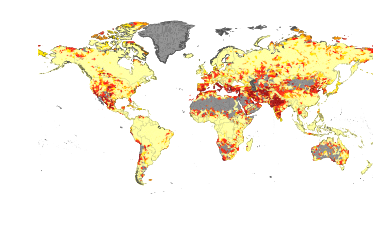

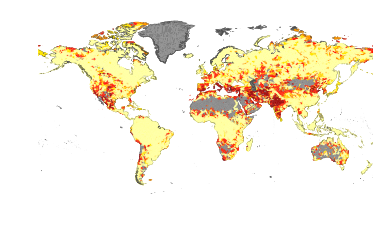

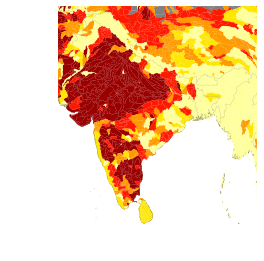

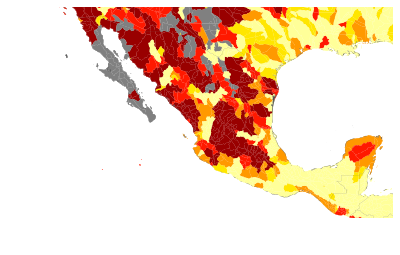

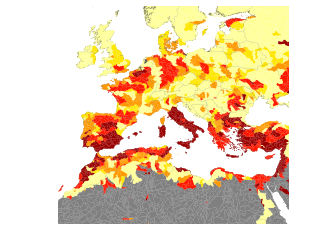

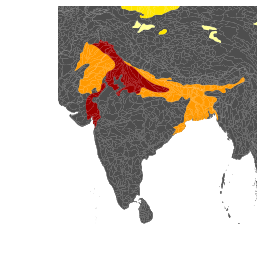

In [16]:
for key, value in settings.items():
  perspective = value["perspective"]
  scope = value["scope"]
  countries = value["countries"]
  buffer = value["buffer"]
  column = value["column"]
  
  all_countries, non_disputed, disputed = get_boundaries(perspective=perspective)

  disputed_projected = disputed.to_crs(miller)
  non_disputed_projected = non_disputed.to_crs(miller)
  all_countries_projected = all_countries.to_crs(miller)
  
  xmin, xmax, ymin, ymax = get_extent_miller(scope,countries,buffer)
  output_filename = "{}/aqueduct30_{}_{:02.0f}".format(output_path,key,OUTPUT_VERSION)
  print(output_filename,perspective, scope,xmin,xmax,ymin,ymax)
  if key == "india_gtd":
    bordercolor = "#ffffff"
  elif key == "global_bws_noborder":
    bordercolor = "None"
  else:
    bordercolor = "#4E4E4E"
  
  plot_aqueduct_bws(column,output_filename,xmin,xmax,ymin,ymax,gdf,disputed_projected,non_disputed_projected,bordercolor)
  

In [17]:
!gsutil -m cp -r {output_path} {GCS_OUTPUT_PATH}

Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_india_bws_07.pdf [Content-Type=application/pdf]...
Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_india_gtd_07.pdf [Content-Type=application/pdf]...
Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_global_bws_07.pdf [Content-Type=application/pdf]...
Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_europemena_bws_07.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_global_bws_noborder_07.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_global_bws_noborder_07.pdf [Content-Type=application/pdf]...
Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_india_bws_07.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D24_RH_Aqueduct30_Plotting_V01/output_V07/aqueduct30_mexico_bws_07.jpg [Conte